In [ ]:
! pip install dowhy

In [ ]:
pip install --upgrade dowhy

In [ ]:
! pip install xgboost

In [ ]:
! pip install mord

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=162cc8c8555e80fca41b75cc0ed2701adca5165a6c5f6588bd841af3a23dfe61
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


In [ ]:
! pip install scikit-learn==1.4.2

# Setup

In [48]:
import sklearn
print(sklearn.__version__)
import pandas as pd
import dowhy
from dowhy import CausalModel, gcm
import networkx as nx
import numpy as np
from dowhy.gcm.falsify import FalsifyConst, falsify_graph, plot_local_insights, run_validations, apply_suggestions
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import dowhy.gcm as gcm
from dowhy.gcm.ml import SklearnRegressionModel
from xgboost import XGBRegressor
import mord

from dowhy.gcm import AdditiveNoiseModel, EmpiricalDistribution
from xgboost import XGBRegressor
import mord


1.4.2


In [ ]:
data = pd.read_csv("long_2000_mean_fire_earth_data.csv")
print(data.columns.tolist())

['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'FIRE_YEAR', 'DISCOVERY_DATE', 'CONT_DATE', 'DURATION_DAYS', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'DISCOVERY_DOY', 'date', 'dead_fuel_100', 'dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C', 'min_temp_C', 'precipitation', 'wind_speed', 'population_density', 'vegetation', 'drought_index']


In [ ]:
data['temp_C'] = (data['min_temp_C'] + data['max_temp_C'])/2
drop_cols = ['FOD_ID', 'FIRE_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'date', 'dead_fuel_100']
data = data.drop(columns=drop_cols)

# Mapping dictionary
class_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8}

# Apply the mapping
data['FIRE_SIZE_CLASS_NUM'] = data['FIRE_SIZE_CLASS'].map(class_mapping)
data = data.dropna()
data_np = data.to_numpy()

print(data.columns.tolist())

['FIRE_SIZE', 'FIRE_SIZE_CLASS', 'CONT_DATE', 'DURATION_DAYS', 'DISCOVERY_DOY', 'dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C', 'min_temp_C', 'precipitation', 'wind_speed', 'population_density', 'vegetation', 'drought_index', 'temp_C', 'FIRE_SIZE_CLASS_NUM']


In [ ]:
ary_data = data.drop(columns=['dead_fuel_1000',
                              'energy_release',
                              #'population_density',
                              'drought_index',
                              #'vegetation',
                              #'precipitation',
                              #'wind_speed',
                              'max_temp_C',
                              'min_temp_C',
                              'DISCOVERY_DOY',
                              'CONT_DATE',
                              'DURATION_DAYS',
                              'FIRE_SIZE_CLASS',
                              'FIRE_SIZE'
                              ])
ary_data = ary_data.dropna()
ary_data_np = ary_data.to_numpy()
print(ary_data.columns.tolist())

['humidity', 'precipitation', 'wind_speed', 'population_density', 'vegetation', 'temp_C', 'FIRE_SIZE_CLASS_NUM']


# Polynomial Models

In [ ]:
# Define causal graph
causal_graph = nx.DiGraph([
    ('humidity','temp_C'),
    ('humidity','wind_speed'),
    ('humidity','precipitation'),
    ('humidity','vegetation'),
    ('humidity','FIRE_SIZE_CLASS_NUM'),

    ('precipitation','wind_speed'),
    ('precipitation','temp_C'),
    ('precipitation','vegetation'),
    ('precipitation','FIRE_SIZE_CLASS_NUM'),

    ('wind_speed','temp_C'),
    ('wind_speed','population_density'),
    ('wind_speed','FIRE_SIZE_CLASS_NUM'),

    ('temp_C','vegetation'),
    ('temp_C','population_density'),
    ('temp_C','FIRE_SIZE_CLASS_NUM'),

    ('population_density','vegetation'),
    ('population_density','FIRE_SIZE_CLASS_NUM'),

    ('vegetation','FIRE_SIZE_CLASS_NUM'),
])

## Linear Model (n=1)

In [82]:
# Create causal model
causal_model_1 = gcm.StructuralCausalModel(causal_graph)
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model_1, ary_data)
print(auto_assignment_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Fitting causal mechanism of node population_density: 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]
Test permutations of given graph: 100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


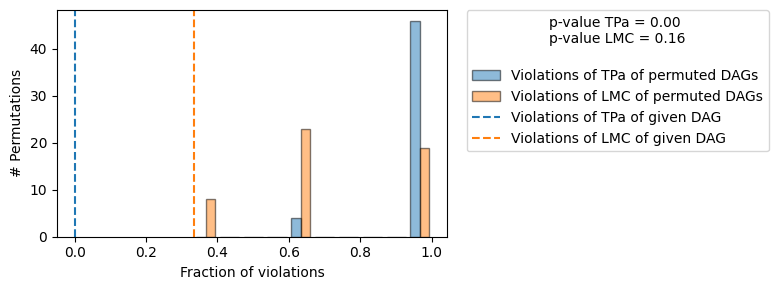

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
# Fit and evaluate
gcm.fit(causal_model_1, ary_data)
evaluation = gcm.evaluate_causal_model(causal_model_1, ary_data)
print(evaluation)

## General Polynomial Model

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from dowhy.gcm import AdditiveNoiseModel
from dowhy.gcm.ml import SklearnRegressionModel

def set_polynomial_mechanisms(causal_model, data, degree=2):
    for node in causal_model.graph.nodes:
        parents = list(causal_model.graph.predecessors(node))

        if not parents:
            # Root node — empirical distribution
            causal_model.set_causal_mechanism(node, gcm.EmpiricalDistribution())
        else:
            # Internal node — polynomial regression
            poly_model = make_pipeline(
                PolynomialFeatures(degree=degree, include_bias=False),
                LinearRegression()
            )
            causal_model.set_causal_mechanism(node, AdditiveNoiseModel(SklearnRegressionModel(poly_model)))

### Quadratic Model (n=2)

Fitting causal mechanism of node population_density: 100%|██████████| 7/7 [00:00<00:00, 15.41it/s]
Test permutations of given graph: 100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


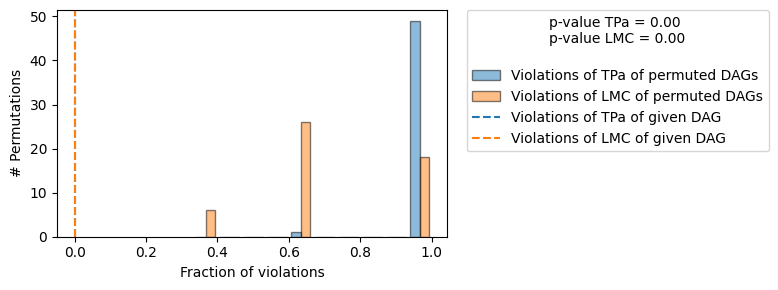

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
causal_model_2 = gcm.StructuralCausalModel(causal_graph)

set_polynomial_mechanisms(causal_model_2, ary_data, degree=2)

gcm.fit(causal_model_2, ary_data)
evaluation = gcm.evaluate_causal_model(causal_model_2, ary_data)
print(evaluation)


### Cubic Model (n=3)

Fitting causal mechanism of node population_density: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]
Test permutations of given graph: 100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


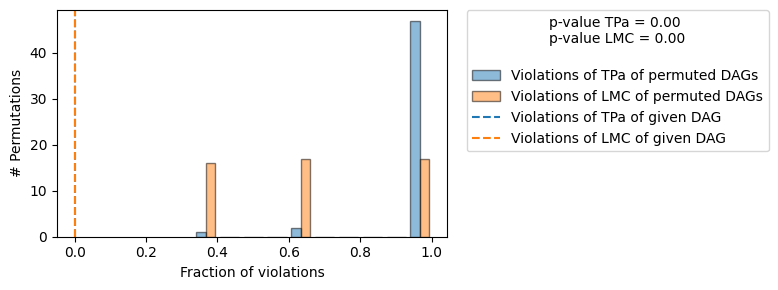

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
causal_model_3 = gcm.StructuralCausalModel(causal_graph)

set_polynomial_mechanisms(causal_model_3, ary_data, degree=3)

gcm.fit(causal_model_3, ary_data)
evaluation = gcm.evaluate_causal_model(causal_model_3, ary_data)
print(evaluation)

### Quartic Model (n=4)

Fitting causal mechanism of node population_density: 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]
Test permutations of given graph: 100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


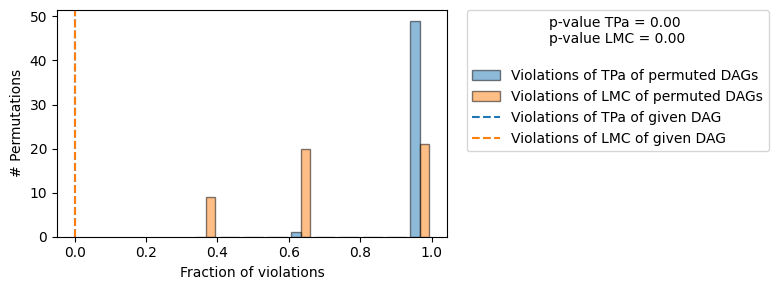

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
causal_model_4 = gcm.StructuralCausalModel(causal_graph)

set_polynomial_mechanisms(causal_model_4, ary_data, degree=4)

gcm.fit(causal_model_4, ary_data)
evaluation = gcm.evaluate_causal_model(causal_model_4, ary_data)
print(evaluation)

# XGBoost and Mord Models

In [ ]:
# Define causal graph
causal_graph = nx.DiGraph([
    ('humidity','temp_C'),
    ('humidity','wind_speed'),
    ('humidity','precipitation'),
    ('humidity','vegetation'),
    ('humidity','FIRE_SIZE_CLASS_NUM'),

    ('precipitation','wind_speed'),
    ('precipitation','temp_C'),
    ('precipitation','vegetation'),
    ('precipitation','FIRE_SIZE_CLASS_NUM'),

    ('wind_speed','temp_C'),
    ('wind_speed','population_density'),
    ('wind_speed','FIRE_SIZE_CLASS_NUM'),

    ('temp_C','vegetation'),
    ('temp_C','population_density'),
    ('temp_C','FIRE_SIZE_CLASS_NUM'),

    ('population_density','vegetation'),
    ('population_density','FIRE_SIZE_CLASS_NUM'),

    ('vegetation','FIRE_SIZE_CLASS_NUM'),
])

In [ ]:
def set_mechanisms_with_xgboost_and_mord(causal_model, data, ordinal_target='FIRE_SIZE_CLASS_NUM'):
    for node in causal_model.graph.nodes:
        parents = list(causal_model.graph.predecessors(node))

        if not parents:
            # Root node: use empirical distribution
            causal_model.set_causal_mechanism(node, EmpiricalDistribution())
        elif node == ordinal_target:
            # Ordinal regression for FIRE_SIZE_CLASS_NUM using mord
            ordinal_model = mord.LogisticAT()
            wrapped_model = SklearnRegressionModel(ordinal_model)
            causal_model.set_causal_mechanism(node, AdditiveNoiseModel(wrapped_model))
        else:
            # All other nodes: use XGBoost
            xgb_model = XGBRegressor(n_estimators=100, max_depth=4, verbosity=0)
            wrapped_model = SklearnRegressionModel(xgb_model)
            causal_model.set_causal_mechanism(node, AdditiveNoiseModel(wrapped_model))


Fitting causal mechanism of node population_density: 100%|██████████| 7/7 [01:19<00:00, 11.37s/it]
Test permutations of given graph: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


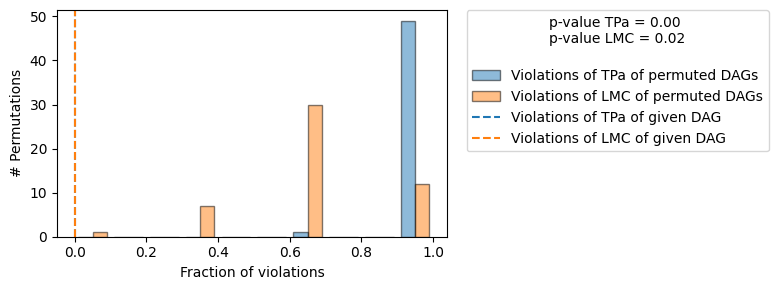

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
# Create causal model
causal_model_xg = gcm.StructuralCausalModel(causal_graph)
set_mechanisms_with_xgboost_and_mord(causal_model_xg, ary_data)
gcm.fit(causal_model_xg, ary_data)
evaluation = gcm.evaluate_causal_model(causal_model_xg, ary_data)
print(evaluation)

# Optimum Mix Model

In [ ]:
# Define causal graph
causal_graph = nx.DiGraph([
    ('humidity','temp_C'),
    ('humidity','wind_speed'),
    ('humidity','precipitation'),
    ('humidity','vegetation'),
    ('humidity','FIRE_SIZE_CLASS_NUM'),

    ('precipitation','wind_speed'),
    ('precipitation','temp_C'),
    ('precipitation','vegetation'),
    ('precipitation','FIRE_SIZE_CLASS_NUM'),

    ('wind_speed','temp_C'),
    ('wind_speed','population_density'),
    ('wind_speed','FIRE_SIZE_CLASS_NUM'),

    ('temp_C','vegetation'),
    ('temp_C','population_density'),
    ('temp_C','FIRE_SIZE_CLASS_NUM'),

    ('population_density','vegetation'),
    ('population_density','FIRE_SIZE_CLASS_NUM'),

    ('vegetation','FIRE_SIZE_CLASS_NUM'),
])

In [ ]:
def set_best_mechanisms(causal_model, data):
    for node in causal_model.graph.nodes:
        parents = list(causal_model.graph.predecessors(node))

        if not parents:
            # Root node → use empirical distribution
            causal_model.set_causal_mechanism(node, EmpiricalDistribution())

        elif node in ['population_density', 'vegetation', 'FIRE_SIZE_CLASS_NUM']:
            # Use LinearRegression for these specific nodes
            lin_model = LinearRegression()
            wrapped_model = SklearnRegressionModel(lin_model)
            causal_model.set_causal_mechanism(node, AdditiveNoiseModel(wrapped_model))

        else:
            # Use XGBoost for remaining internal nodes
            xgb_model = XGBRegressor(n_estimators=100, max_depth=4, verbosity=0)
            wrapped_model = SklearnRegressionModel(xgb_model)
            causal_model.set_causal_mechanism(node, AdditiveNoiseModel(wrapped_model))

Fitting causal mechanism of node population_density: 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]
Test permutations of given graph: 100%|██████████| 50/50 [00:39<00:00,  1.28it/s]


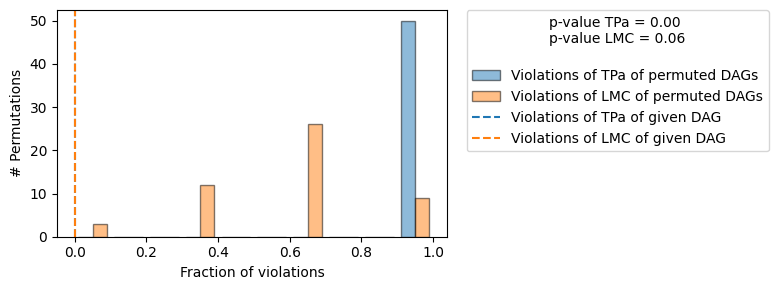

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
causal_model_mix = gcm.StructuralCausalModel(causal_graph)
set_best_mechanisms(causal_model_mix, ary_data)
gcm.fit(causal_model_mix, ary_data)
evaluation = gcm.evaluate_causal_model(causal_model_mix, ary_data)
print(evaluation)

# Further Optimised with Ridge

In [ ]:
# Define causal graph
causal_graph = nx.DiGraph([
    ('humidity','temp_C'),
    ('humidity','wind_speed'),
    ('humidity','precipitation'),
    ('humidity','vegetation'),
    ('humidity','FIRE_SIZE_CLASS_NUM'),

    ('precipitation','wind_speed'),
    ('precipitation','temp_C'),
    ('precipitation','vegetation'),
    ('precipitation','FIRE_SIZE_CLASS_NUM'),

    ('wind_speed','temp_C'),
    ('wind_speed','population_density'),
    ('wind_speed','FIRE_SIZE_CLASS_NUM'),

    ('temp_C','vegetation'),
    ('temp_C','population_density'),
    ('temp_C','FIRE_SIZE_CLASS_NUM'),

    ('population_density','vegetation'),
    ('population_density','FIRE_SIZE_CLASS_NUM'),

    ('vegetation','FIRE_SIZE_CLASS_NUM'),
])

In [ ]:
def set_refined_mechanisms(causal_model, data):
    for node in causal_model.graph.nodes:
        parents = list(causal_model.graph.predecessors(node))

        if not parents:
            # Root node → use empirical distribution
            causal_model.set_causal_mechanism(node, EmpiricalDistribution())

        elif node == 'population_density':
            # Use Ridge regression for population_density
            ridge_model = Ridge(alpha=1.0)
            wrapped_model = SklearnRegressionModel(ridge_model)
            causal_model.set_causal_mechanism(node, AdditiveNoiseModel(wrapped_model))

        elif node in ['vegetation', 'FIRE_SIZE_CLASS_NUM']:
            # Use LinearRegression for these specific nodes
            lin_model = LinearRegression()
            wrapped_model = SklearnRegressionModel(lin_model)
            causal_model.set_causal_mechanism(node, AdditiveNoiseModel(wrapped_model))

        else:
            # Use XGBoost for remaining internal nodes
            xgb_model = XGBRegressor(n_estimators=100, max_depth=4, verbosity=0)
            wrapped_model = SklearnRegressionModel(xgb_model)
            causal_model.set_causal_mechanism(node, AdditiveNoiseModel(wrapped_model))

Fitting causal mechanism of node population_density: 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]
Test permutations of given graph: 100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


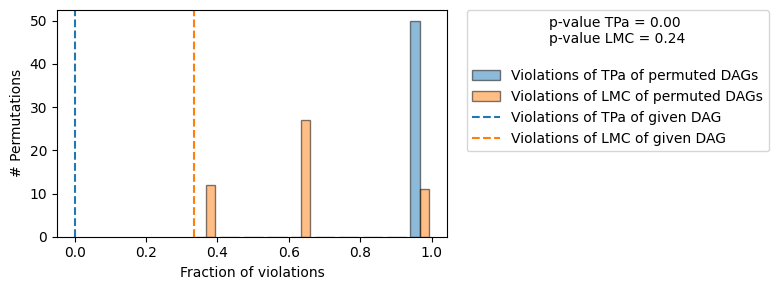

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
causal_model_refined = gcm.StructuralCausalModel(causal_graph)
set_refined_mechanisms(causal_model_refined, ary_data)
gcm.fit(causal_model_refined, ary_data)
evaluation = gcm.evaluate_causal_model(causal_model_refined, ary_data)
print(evaluation)

# Visualizing Output

## Linear Model (n=1)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Fitting causal mechanism of node population_density: 100%|██████████| 7/7 [00:00<00:00, 86.05it/s]
Test permutations of given graph: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


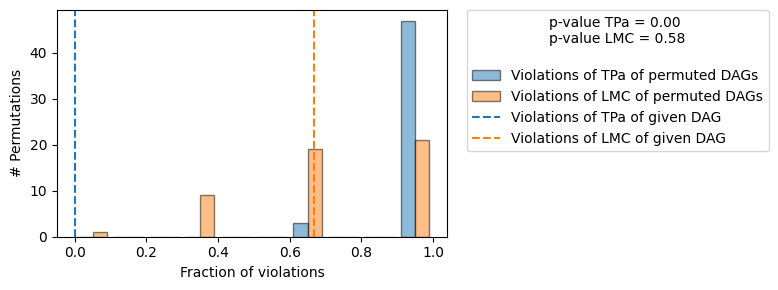

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [95]:
from sklearn.model_selection import train_test_split

# 1. Split the dataset
train_data, test_data = train_test_split(ary_data, test_size=0.2, random_state=42)

# 2. Define graph and model
causal_model = gcm.StructuralCausalModel(causal_graph)
print(gcm.auto.assign_causal_mechanisms(causal_model, train_data))

# 3. Fit on training data only (no evaluation)
gcm.fit(causal_model, train_data)
evaluation = gcm.evaluate_causal_model(causal_model_1, ary_data)
print(evaluation)

In [91]:
import matplotlib.pyplot as plt

def extract_linear_coefficients(causal_model):
    edge_coefs = {}

    for child in causal_model.graph.nodes:
        try:
            mechanism = gcm.auto.get_causal_mechanism(causal_model, child)
        except Exception:
            continue

        if not hasattr(mechanism, "prediction_model"):
            continue

        model = mechanism.prediction_model

        # If model is a pipeline, grab the last step (assumed to be LinearRegression)
        if hasattr(model, "named_steps"):
            final_model = model.named_steps.get("linearregression", None)
        elif hasattr(model, "steps"):
            final_model = model.steps[-1][1]  # Last step is the regressor
        else:
            final_model = model  # Fallback

        if hasattr(final_model, "coef_"):
            parents = list(causal_model.graph.predecessors(child))
            for i, parent in enumerate(parents):
                edge_coefs[(parent, child)] = final_model.coef_[i]

    return edge_coefs




In [92]:
extract_linear_coefficients(causal_model)

{}

In [89]:
def inspect_mechanism_types(causal_model):
    types = {}
    for node in causal_model.graph.nodes:
        try:
            mech = gcm.auto.get_causal_mechanism(causal_model, node)
            types[node] = type(mech).__name__
        except Exception:
            types[node] = "None"
    return types

In [90]:
inspect_mechanism_types(causal_model)

{'humidity': 'None',
 'temp_C': 'None',
 'wind_speed': 'None',
 'precipitation': 'None',
 'vegetation': 'None',
 'FIRE_SIZE_CLASS_NUM': 'None',
 'population_density': 'None'}

In [105]:
import numpy as np

for node, mechanism in causal_model._causal_mechanisms.items():
    if hasattr(mechanism, 'noise_model'):
        mechanism.noise_model = lambda n: np.zeros(n)

AttributeError: 'StructuralCausalModel' object has no attribute '_causal_mechanisms'

In [108]:
generated_data = gcm.draw_samples(causal_model, num_samples=10000)

In [109]:
print(generated_data.head())

   humidity  precipitation  wind_speed     temp_C  population_density  \
0  0.002748      -0.482812    3.512671   6.676423         -137.238758   
1  0.006080       0.255875    5.513371  14.750540           50.093912   
2  0.007935      13.237650    4.454898  17.925271           82.316657   
3  0.006122      -0.862061    4.025567  18.169945          110.151712   
4  0.002139      -2.052003    7.633438  11.188988          256.255850   

    vegetation  FIRE_SIZE_CLASS_NUM  
0  3038.565895             1.496663  
1  3880.085702             2.092141  
2  3640.507149            -0.076097  
3   624.918535             0.972080  
4  2913.258478             4.212402  


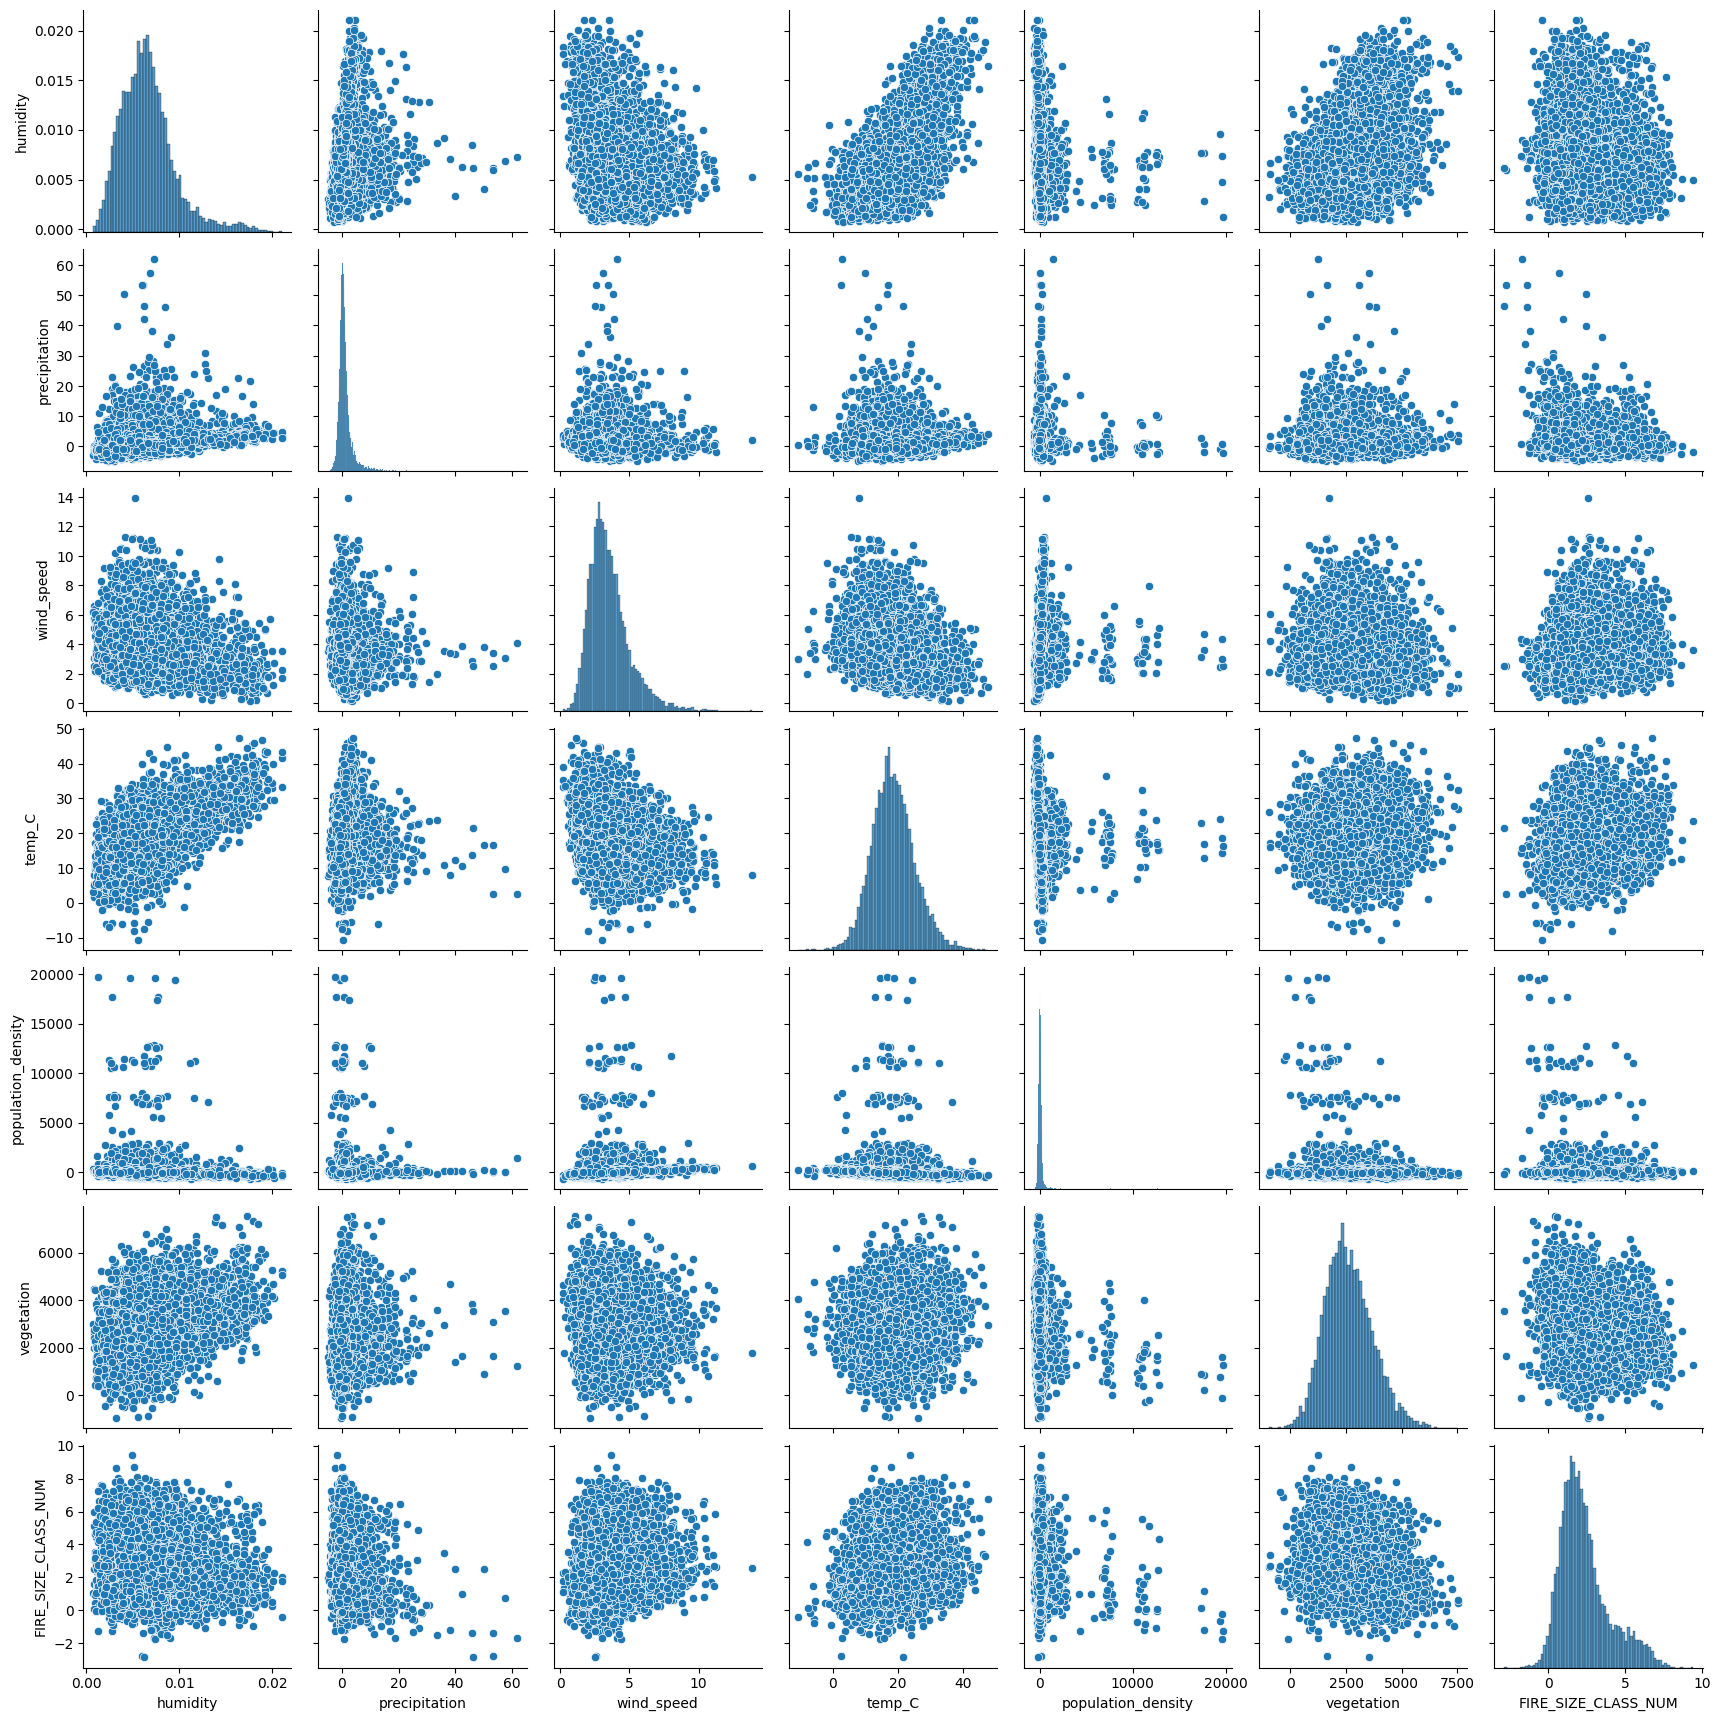

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called df
sns.pairplot(generated_data)
plt.show()

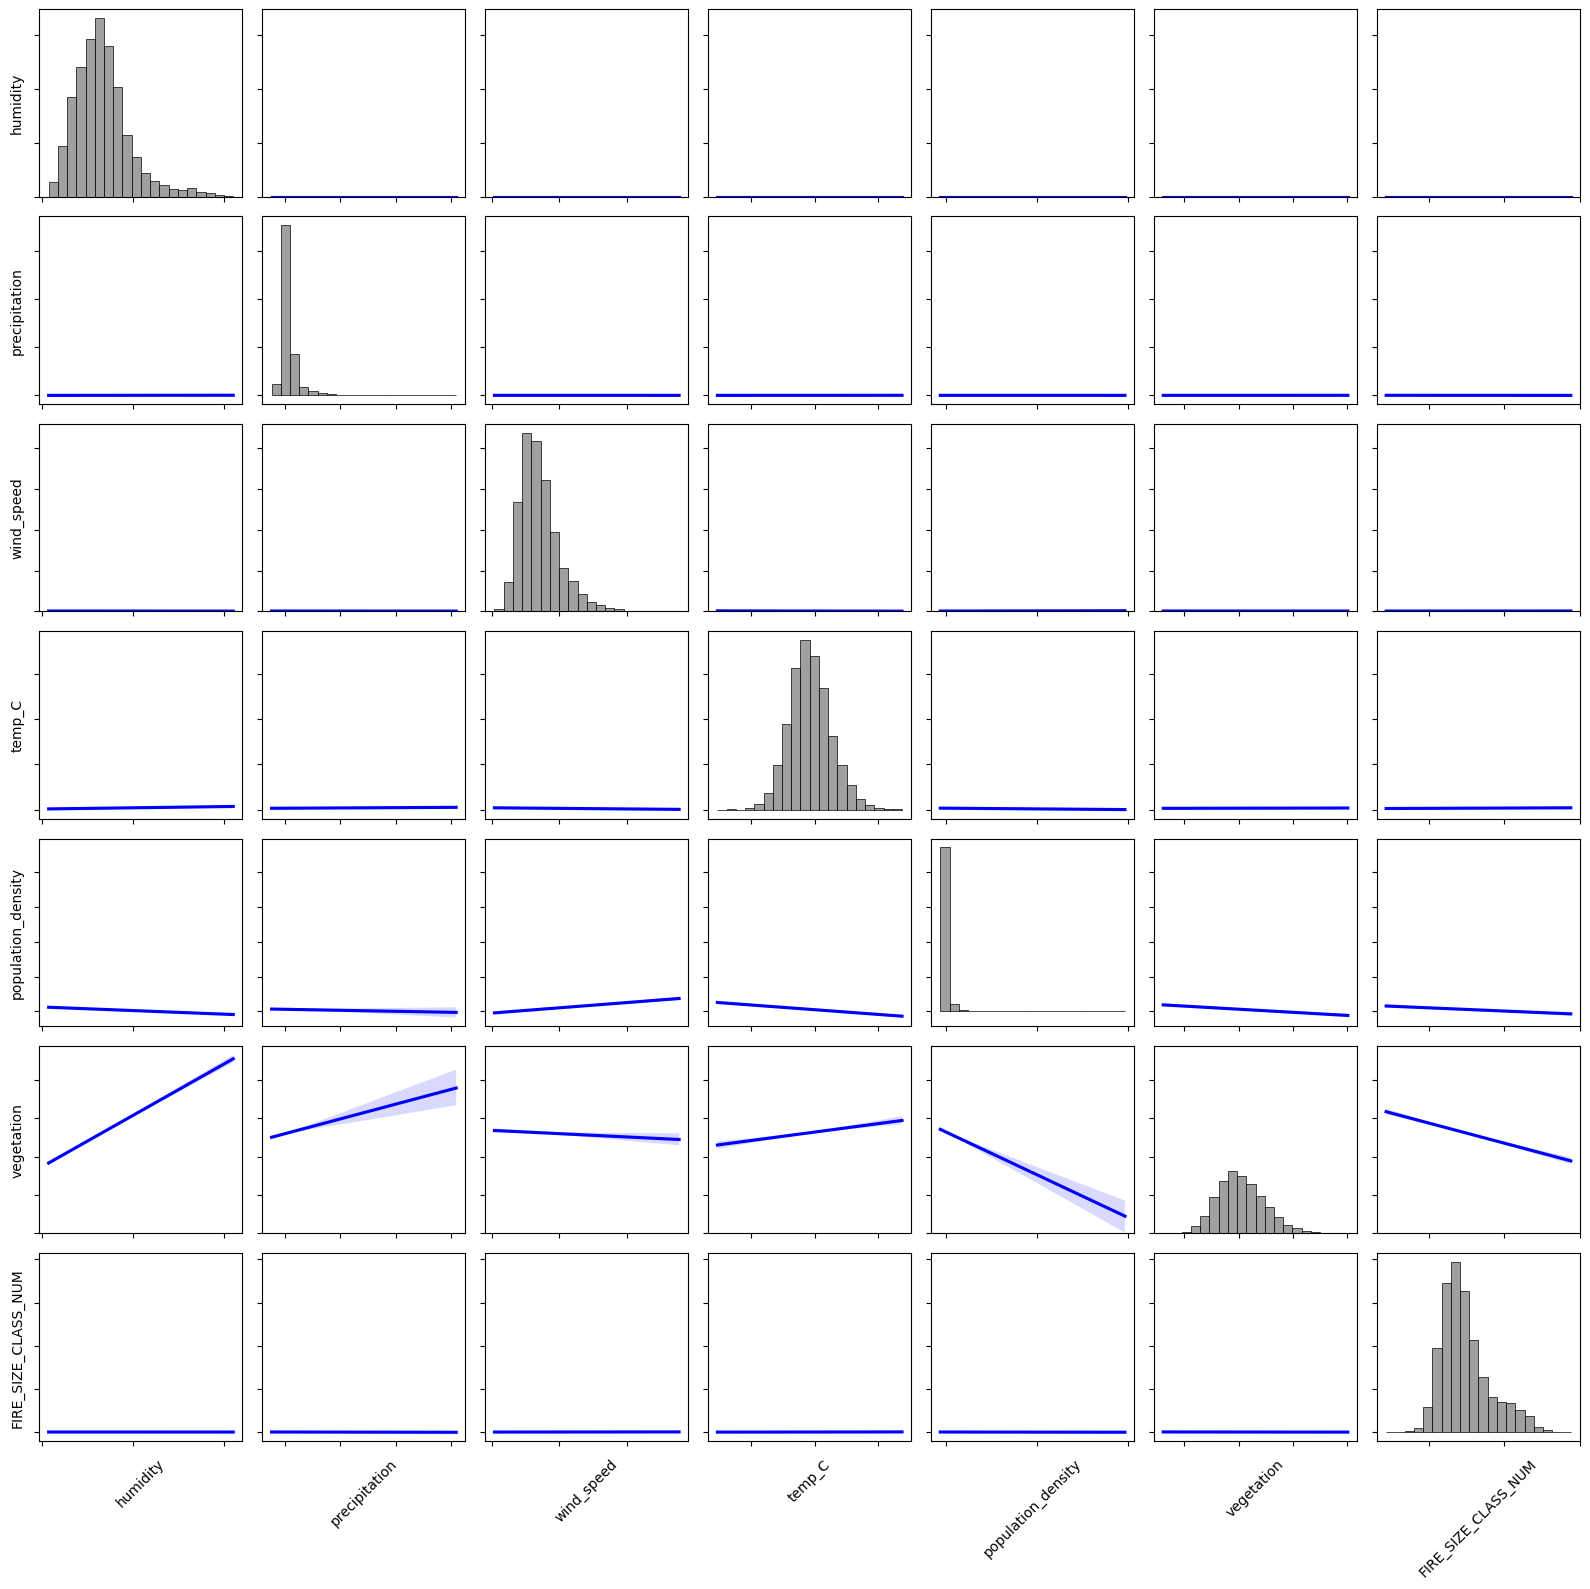

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ['humidity', 'precipitation', 'wind_speed', 'temp_C',
        'population_density', 'vegetation', 'FIRE_SIZE_CLASS_NUM']
n = len(cols)

fig, axes = plt.subplots(n, n, figsize=(16, 16), sharex='col', sharey='row')

for i, row_var in enumerate(cols):
    for j, col_var in enumerate(cols):
        ax = axes[i, j]
        if i == j:
            sns.histplot(generated_data[row_var], ax=ax, bins=20, color='gray')
        else:
            sns.regplot(
                data=generated_data,
                x=col_var,
                y=row_var,
                ax=ax,
                scatter=False,   # No scatter points
                line_kws={'color': 'blue'}
            )
        if i == n - 1:
            ax.set_xlabel(col_var, rotation=45)
        else:
            ax.set_xlabel("")
            ax.set_xticklabels([])
        if j == 0:
            ax.set_ylabel(row_var)
        else:
            ax.set_ylabel("")
            ax.set_yticklabels([])

plt.tight_layout()
plt.show()